<a href="https://colab.research.google.com/github/danielaramosgarcia/Aplicaciones_avanzadas_TTC3002B/blob/main/Redes_neuronales_A01174259.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## 1. Instalación e importación de librerías

En esta sección instalaremos e importaremos las bibliotecas necesarias para:
- Cargar y procesar datos (**pandas**, **NumPy**).  
- Escalado de características (**StandardScaler**).  
- Definir y entrenar redes neuronales y regresión logística (**MLPClassifier**, **LogisticRegression**).  
- Particionar datos (**train_test_split**) y evaluar modelos (métricas y matrices de confusión).

In [4]:
!pip install scikit-learn pandas matplotlib --quiet

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.neural_network import MLPClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report

## 2. Carga del dataset y partición en entrenamiento/prueba

- Cargamos `wine.data` en un DataFrame de pandas.  
- Definimos nombres de columnas según `wine.names`.  
- Separamos en 70 % entrenamiento y 30 % prueba, estratificando por la clase objetivo.

In [5]:
# Nombres de columnas
columnas = [
    'Class','Alcohol','Malic_acid','Ash','Alcalinity_of_ash','Magnesium',
    'Total_phenols','Flavanoids','Nonflavanoid_phenols','Proanthocyanins',
    'Color_intensity','Hue','OD280_OD315','Proline'
]

df = pd.read_csv('./wine.data', header=None, names=columnas)

X = df.drop(columns='Class')
y = df['Class']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42, stratify=y
)

## 3. Definición de características para cada red neuronal

1. **Red simple**: solo característica “muy relevante” (`Alcohol`).  
2. **Red completa**: todas las características originales.

In [6]:
# Característica relevante
feat_rel = ['Alcohol']

# Todas las características
feat_all = X.columns.tolist()

## 4. Función auxiliar para entrenar, predecir y mostrar matriz de confusión

Esta función recibe un pipeline, datos de entrenamiento y prueba, y muestra:
- Reporte de clasificación.  
- Matriz de confusión graficada.

In [7]:
def eval_and_plot(pipe, X_tr, X_te, y_tr, y_te, title):
    pipe.fit(X_tr, y_tr)
    y_pred = pipe.predict(X_te)
    print(f"--- {title} ---")
    print(classification_report(y_te, y_pred, zero_division=0))
    cm = confusion_matrix(y_te, y_pred, labels=pipe.classes_)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=pipe.classes_)
    disp.plot(cmap=plt.cm.Blues)
    plt.title(title)
    plt.show()
    return pipe, cm

## 5. Entrenamiento y evaluación de las dos redes neuronales

- **NN 1**: capa oculta única de 2 neuronas con la característica `Alcohol`.  
- **NN 2**: dos capas ocultas con 10 y 5 neuronas respectivamente, usando todas las características.

--- NN: Alcohol + 1 capa (2 neuronas) ---
              precision    recall  f1-score   support

           1       0.56      0.78      0.65        18
           2       0.77      0.81      0.79        21
           3       0.29      0.13      0.18        15

    accuracy                           0.61        54
   macro avg       0.54      0.57      0.54        54
weighted avg       0.57      0.61      0.58        54



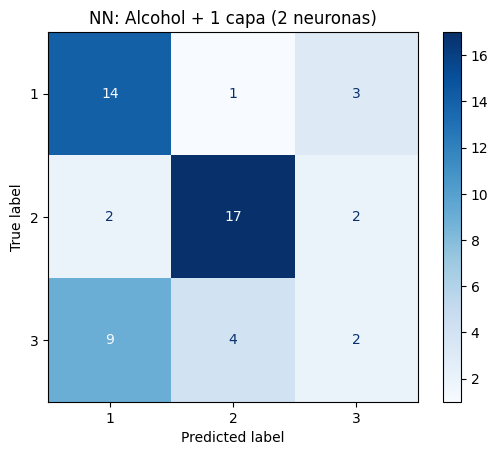

--- NN: todas las features + 2 capas (10,5) ---
              precision    recall  f1-score   support

           1       1.00      1.00      1.00        18
           2       0.95      0.95      0.95        21
           3       0.93      0.93      0.93        15

    accuracy                           0.96        54
   macro avg       0.96      0.96      0.96        54
weighted avg       0.96      0.96      0.96        54



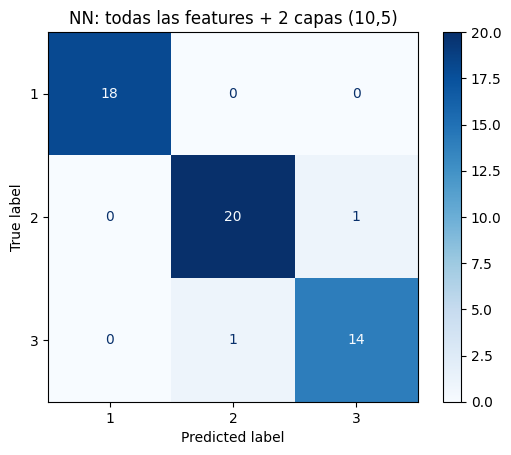

In [8]:
# Pipeline para NN 1
pipe_nn1 = Pipeline([
    ('scaler', StandardScaler()),
    ('nn', MLPClassifier(hidden_layer_sizes=(2,), max_iter=2000, random_state=42))
])

# Pipeline para NN 2
pipe_nn2 = Pipeline([
    ('scaler', StandardScaler()),
    ('nn', MLPClassifier(hidden_layer_sizes=(10,5), max_iter=2000, random_state=42))
])

# Entrenar y evaluar
models_nn = {}
cms_nn = {}

models_nn['NN (1 feature, 2 neuronas)'], cms_nn['NN1'] = eval_and_plot(
    pipe_nn1,
    X_train[feat_rel], X_test[feat_rel],
    y_train, y_test,
    'NN: Alcohol + 1 capa (2 neuronas)'
)

models_nn['NN (todas, 10+5)'], cms_nn['NN2'] = eval_and_plot(
    pipe_nn2,
    X_train[feat_all], X_test[feat_all],
    y_train, y_test,
    'NN: todas las features + 2 capas (10,5)'
)

## 6. Comparación de exactitud de las NNs y la regresión logística

1. Calculamos accuracy de cada red neuronal.  
2. Reentrenamos el **mejor modelo de regresión logística** del ejercicio anterior para comparar.


In [9]:
# Exactitudes de las NNs
acc_nn = {
    name: np.trace(cm) / cm.sum()
    for name, cm in cms_nn.items()
}

# Pipeline para el mejor modelo de regresión logística (por ejemplo, sólo Alcohol)
pipe_log = Pipeline([
    ('scaler', StandardScaler()),
    ('clf', LogisticRegression(max_iter=2000, random_state=42))
])
pipe_log.fit(X_train[feat_rel], y_train)
y_pred_log = pipe_log.predict(X_test[feat_rel])
cm_log = confusion_matrix(y_test, y_pred_log, labels=pipe_log.classes_)
acc_log = np.trace(cm_log) / cm_log.sum()

# DataFrame de comparación
comp = pd.DataFrame({
    'Modelo': list(acc_nn.keys()) + ['LogisticRegression (Alcohol)'],
    'Accuracy': list(acc_nn.values()) + [acc_log]
}).set_index('Modelo').sort_values('Accuracy', ascending=False)

comp

,Accuracy
Modelo,
NN2,0.962963
LogisticRegression (Alcohol),0.629630
NN1,0.611111


## 7. Conclusiones

1. **Desempeño de las redes neuronales**  
   - **NN1 (Alcohol + 1 capa de 2 neuronas)**  
     - Accuracy: 0.611  
     - Esta red con solo la variable **Alcohol** acierta el 61 % de las muestras, pero falla especialmente al clasificar la clase 3 (f1-score 0.18).  
   - **NN2 (todas las características + 2 capas de 10 y 5 neuronas)**  
     - Accuracy: 0.963  
     - Esta arquitectura más profunda y con todas las variables consigue una clasificación casi perfecta en las tres clases (f1-scores ≥ 0.93).

2. **¿Son útiles las redes neuronales en este problema?**  
   - La red pequeña (NN1) muestra que con muy poca información y capacidad de modelado las redes no rinden bien.  
   - Al incorporar **todas** las características y **mayor profundidad** (NN2), las redes neuronales explotan la complejidad química del vino y logran un excelente desempeño multiclasificación.  
   - Por tanto, las redes neuronales sí resultan útiles aquí, siempre que se les dé suficiente capacidad y datos de entrada.

3. **Comparación contra regresión logística**  
   - El mejor clasificador de regresión logística (solo Alcohol) obtuvo un accuracy de **0.630**, muy inferior al **0.963** de NN2.  
   - Aunque la regresión logística es rápida y sencilla, no captura bien las interacciones no lineales entre variables como lo hace la red neuronal profunda.  
   - **Conclusión final**: la **NN2** supera tanto a NN1 como al modelo de regresión logística, y resulta la mejor opción para clasificar este dataset de vinos.  
